<a href="https://colab.research.google.com/github/CarolinaKra/WineQualityPredictor/blob/main/WineQuality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#this is to avoid randomisation when running the code
import numpy as np
import tensorflow as tf
seed_val = 987
np.random.seed(seed_val)
tf.random.set_seed(seed_val)
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
tf.compat.v1.keras.backend.set_session(sess)

# Introducction
## 1. Define the problem:

Can we predict a wine's sensory quality by its physicochemical properties?

There are far fewer wine experts than wineries in the world. Only wine experts can qualify a wine by its sensory qualities

On the other hand, wineries can purchase analytical equipment that can accurately measure the physicochemical properties of wine, such as its alcohol and sugar content, as well as its acidity.

Wineries would be able to develop good quality wines faster if they could predict the quality of wine based on its physicochemical properties.

For this project, we will work with a dataset containing the physicochemical properties of 4898 samples of wines as input and their quality scores (0-9) provided by wine experts. The input data consists of  11 numerical continuous variables while the output data consists of a single discrete numerical value. 
As the output is discrete and not continuous, the problem can be considered a single label multiclass classification problem.

Two hypotheses are made:
1. The physical properties of wine can be used to predict its sensory quality.
2. The available dataset is informative enough to learn the relationship between wine properties and its sensory quality.

## 2. Set the measure of success
In the second stage, we must choose a measure of success, from which we can calculate the error and from which we will obtain the loss function. Because we are dealing with a single label multiclass classification problem, we will choose accuracy as the measure of success.


## 3. Set an evaluation protocol
We will create a model by using Deep Neural Networks with Tensorflow 2.0 and the Keras package on the given data. The model will be optimised by finding the best hyperparameters. This will be done by using a subset of data called the "training set".
It is important that we do not overfit the data to the training data, therefore we will use a "validation set". We will be able to evaluate the values of different hyperparameters so we can optimize the learning process while preventing overfitting. 
The end goal of the model is to generalise, which means, to help us predict the wine quality, given the properties of new un-seen wine. In order to evaluate how well the model generalises, we use part of the data as test set.

An evaluation protocol specifies how we evaluate the model using training and validation data. We will choose the protocol "one hold-out validation" for this particular problem. We train the model with training data and test it with validation data once for every epoch. We can determine how to tune the hyperparameters further once we have the training and validation looses for the model.

# Methodology and Partial Results
## 4. Load and prepare the data

tensorflow_datasets contains the wine quality dataset, which we can download directly "as supervised" and after the data has been shuffled.

In [2]:
#load data  and shuffling
import tensorflow_datasets as tfds
train_features, train_labels= tfds.as_numpy(tfds.load('wine_quality', split='train', as_supervised=True, batch_size=-1, shuffle_files=True)) 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/wine_quality/white/1.0.0.incompleteI11GW2/wine_quality-train.tfrecord


  0%|          | 0/4898 [00:00<?, ? examples/s]

Dataset wine_quality downloaded and prepared to /root/tensorflow_datasets/wine_quality/white/1.0.0. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [3]:
#exploring the features
train_features

{'alcohol': array([ 9. , 12.2, 11.2, ...,  8.7, 10.6, 12.8], dtype=float32),
 'chlorides': array([0.054, 0.063, 0.029, ..., 0.051, 0.031, 0.029], dtype=float32),
 'citric acid': array([0.34, 0.49, 0.11, ..., 0.59, 0.28, 0.28], dtype=float32),
 'density': array([1.0008 , 0.9911 , 0.99076, ..., 0.99886, 1.00295, 0.99054],
       dtype=float32),
 'fixed acidity': array([7.6, 6.3, 5.3, ..., 8.1, 6.8, 6.6], dtype=float32),
 'free sulfur dioxide': array([44., 35.,  6., ..., 60., 27., 12.], dtype=float32),
 'pH': array([3.22, 3.38, 3.51, ..., 2.96, 3.06, 3.19], dtype=float32),
 'residual sugar': array([18.35,  1.2 ,  1.1 , ..., 13.6 , 26.05,  6.1 ], dtype=float32),
 'sulphates': array([0.55000001, 0.41999999, 0.47999999, ..., 0.38999999, 0.41999999,
        0.27000001]),
 'total sulfur dioxide': array([197.,  92.,  51., ..., 134., 122.,  93.], dtype=float32),
 'volatile acidity': array([0.32, 0.27, 0.43, ..., 0.36, 0.45, 0.36], dtype=float32)}

In [4]:
#getting the amount of features
len(train_features)

11

There are evelen features which comes come as a dictionary. We will process it as a numpy array and then we scale the values so each feature has values within a small range around 0 with a standard deviation of 1.

In [5]:
#as the training feature comes as a form of a diccionary which is difficult to process, I will convert it into a numpy array
features=np.array(list(train_features.values())).T

In [6]:
#I scale the features with a mean of 0 and a standard deviation of 1.
mean=features.mean(axis=0)
std= features.std(axis=0)
features= (features-mean)/std

The labels will be vectorised after we have treated the inputs. This will facilitate the training process. Depending on its input, each wine sample will receive a probability of being classified as one of the classes.

In [7]:
#I convert the labels into one-hot encoding vectors
from tensorflow.keras.utils import to_categorical 
one_hot_labels = to_categorical(train_labels)

In [8]:
print('original label:', end='\t')
print(train_labels[0])
print('vector label:', end='\t')
print(one_hot_labels[0])


original label:	5
vector label:	[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Finally, we need to split the data into the training, validation and test sets, this will be done both for the features (x) and the labels(y).

In [9]:
#split into train, validation and test sets by 70%,15%,15%
samples_no=features.shape[0]
x_train=features[:int(samples_no*0.7)]
y_train=one_hot_labels[:int(samples_no*0.7)]
x_val=features[int(samples_no*0.7):int(samples_no*0.85)]
y_val=one_hot_labels[int(samples_no*0.7):int(samples_no*0.85)]
x_test=features[int(samples_no*0.85):]
y_test=one_hot_labels[int(samples_no*0.85):]


## 5. Develope a model that does better than a baseline model.
We will first create a baseline model to see if it is possible to generate a model that has statistical power. To accomplish this, we will build a simple Neural Network model.

We will now select three important features that should be fixed across the whole project:
* last layer activation function: "softmax"
* loss function: "categorical cross entrophy"
* optimisation configuration: "adam" optimiser 



In [10]:
#create a baseline model
from sklearn.dummy import DummyClassifier
baseline_model=DummyClassifier().fit(features,train_labels)
baseline_model.score(features, train_labels)

0.44875459371171905

We see that the minimum accuracy that we can get with a baseline classifier is 44.87%. This looks odd, for a dataset that should contain label values from 0 to 9.

We will visualise the distribution of the labels.

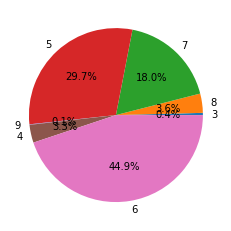

In [11]:
import matplotlib.pyplot as plt
(unique, counts) = np.unique(train_labels, return_counts=True)
frequencies = np.asarray((unique, counts)).T
np.random.shuffle(frequencies)
plt.pie(frequencies[:,1], labels=frequencies[:,0],autopct='%1.1f%%')
plt.show()

The above pie chart shows that the most common label for the dataset is the number 6, while 5 and 7 are the second and third most common. These 3 labels account for most of the 90% of the sample data. 
From this, we can understand that the task of classification won't be easy.

## Creation of helper function and Class

We will start by creating a function for model building and a Class where we could store the results and methods to visualise these results.
In the "build_model" function, we will be able to tune 3 hyperparameters:
The number of hidden layers, the number of nodes per hidden layer and the activation function on the hidden layers,
The output layer will be fixed with 10 nodes and the activation function of softmax which allow us to get the probabilities for each of the classes.

The Class "Trial" will help store the results of the different trials and visualise the training and validation losses against the number of epochs as well as the  training and validation accuracy against the number of epochs

In [12]:
from tensorflow.keras import models, layers

#create a function for a model which variables can be tuned
def build_model(hidden_layers=1,nodes_no=8, activation='relu'):
    model=models.Sequential()
    for i in range(hidden_layers):
        if i==0:
            model.add(layers.Dense(nodes_no, activation=activation, input_shape=(11,)))
        else:
            model.add(layers.Dense(nodes_no, activation=activation))
    model.add(layers.Dense(10, activation = 'softmax'))
    model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['accuracy'])
    return model

In [13]:
#Create a class trial where I am storing the results and functions to visualise the results
class Trial:
    def __init__(self, nodes_no, hidden_layers, activation, reg, dropout, MinValLoss, MaxValAccuracy, history):
        self.nodes_no=nodes_no
        self.hidden_layers=hidden_layers
        self.activation=activation
        self.reg=reg
        self.dropout=dropout
        self.MinValLoss=MinValLoss
        self.MaxValAccuracy=MaxValAccuracy
        self.history=history
    def plot_loss_vs_epochs(self, epochs, start_plot=0):
        epochs_range=range(start_plot+1,epochs+1)
        plt.plot(epochs_range, self.history.history['loss'][start_plot:], 'bo', label='Training loss')
        plt.plot(epochs_range, self.history.history['val_loss'][start_plot:], 'b', label='Validation loss')
        if self.dropout:
            plt.title('Training and validation loss, model with {} layers, {} nodes, {} and dropout regulariser'.format(
                self.hidden_layers,self.nodes_no, self.activation))
        else:
            plt.title('Training and validation loss, model with {} layers, {} nodes and {}'.format(
                self.hidden_layers,self.nodes_no, self.activation))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    def plot_accuracy_vs_epochs(self,epochs, start_plot=0):
        epochs_range=range(start_plot+1,epochs+1)
        plt.plot(epochs_range, self.history.history['accuracy'][start_plot:], 'bo', label='Training accuracy')
        plt.plot(epochs_range, self.history.history['val_accuracy'][start_plot:], 'b', label='Validation accuracy')
        if self.dropout:
            plt.title('Training and validation accuracy, model with {} layers, {} nodes, {} and dropout regulariser'.format(
                self.hidden_layers,self.nodes_no, self.activation))
        else:  
            plt.title('Training and validation accuracy, model with {} layers, {} nodes, and {}'.format(
                self.hidden_layers,self.nodes_no, self.activation))
        plt.xlabel('Epochs')
        plt.ylabel('accuracy')
        plt.legend()
        plt.show()

For the initial model, we create a simple model with 1 hidden layer with 30 nodes and relu as activation function.

In [14]:
#define training parameteres
epochs=40
batch_size=100

In [15]:
#first model
hidden_layers=1
nodes_no=30
activation='relu'
model1=build_model(hidden_layers, nodes_no, activation=activation)
history1=model1.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val,y_val), verbose=0)

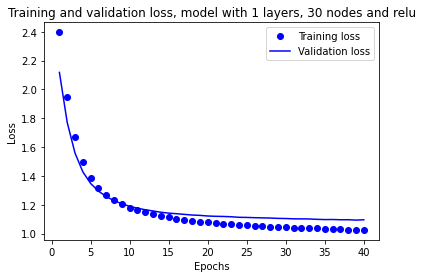

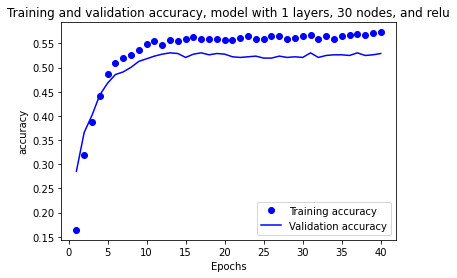

In [16]:
first_trial=Trial(nodes_no, hidden_layers, activation, False,False, min(history1.history['val_loss']), max(history1.history['val_accuracy']), history1)

first_trial.plot_loss_vs_epochs(epochs)
first_trial.plot_accuracy_vs_epochs(epochs)

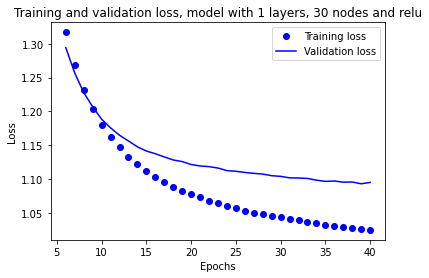

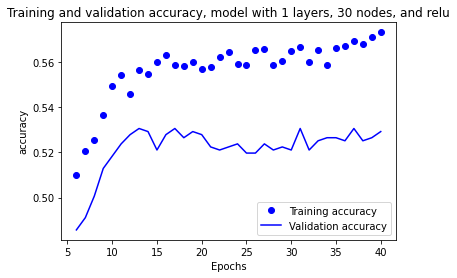

In [17]:
#plot the same graphs starting from the 5th epoch
first_trial.plot_loss_vs_epochs(epochs, 5)
first_trial.plot_accuracy_vs_epochs(epochs,5)

In [18]:
model1.evaluate(x_test,y_test)

23/23 [==============================] - 0s 1ms/step - loss: 1.0360 - accuracy: 0.5565


[1.0360296964645386, 0.5564625859260559]

The first model successfully achieves statistical power as it achieves more than 10% accuracy than the baseline model.

On the other hand, we can observe that the validation loss continues to decrease with the number of epochs hence it didn't overfit the data, but from the accuracy graph, we could see that the validation accuracy has reached a plateau.

We can infer that we need to scale up the model significantly, both to get better training and to reach some overfit that can later be reduced by regularisation.

## 6. Scaling up: Develope a model that overfits


I used my Design of Experiments skills to evaluate different models with different hyperparameters, scaling up the initial model. 

There are 3 desired hyperparameters to investigate:
1. number of nodes (numerical)
2. number of layers (numerical)
3. activation function type (categorical, 2 possible values).

If we need to evaluate 3 possible values for the numerical variables and the 2 possible values for the categorical hyperparameter, we should run 3x3x2=18 experiments. This is called the "full screening design". 

Typically, experiments take a lot of time and money, so smaller designs enable us to explore the full experimental space without wasting resources on unnecessary experiments. In addition, neural networks models have the risk of leaking information from the validation set to the model, which makes the validation set no longer useful as a validation. For this reason, I decided to do a design of experiments with half the number of experiments of a full screening design plus 1 (10 experiments), covering the full experimental field, having 2 centre points where I can compare on the same numerical hyperparameters, the two activation functions. 

After the initial exploration is done, further experiments can be done in a small area of interest to optimise the model further.

In [19]:
#create the experimental table
import pandas as pd
experiment_table=pd.DataFrame({'trial':[1,2,3,4,5,6,7,8,9,10],'nodes_no':[50,50,50,100,100,100,100,150,150,150],
                               'layers':[2,4,5,2,4,4,5,2,4,5],
                               'activation':['relu','tanh','relu','tanh','relu','tanh','tanh','relu','tanh','relu']})
experiment_table

,trial,nodes_no,layers,activation
0,1,50,2,relu
1,2,50,4,tanh
2,3,50,5,relu
3,4,100,2,tanh
4,5,100,4,relu
5,6,100,4,tanh
6,7,100,5,tanh
7,8,150,2,relu
8,9,150,4,tanh
9,10,150,5,relu


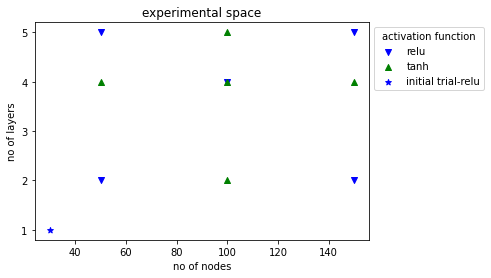

In [25]:
#I visualise the experiment desing together with the initial trial
relus=experiment_table.loc[experiment_table['activation']=='relu']
tanhs=experiment_table.loc[experiment_table['activation']=='tanh']
plt.scatter(relus['nodes_no'],relus['layers'], c='blue', marker='v',label='relu')
plt.scatter(tanhs['nodes_no'],tanhs['layers'],c='green', marker='^', label='tanh')
plt.scatter(30,1,c='blue', marker='*',label='initial trial-relu')
plt.xlabel('no of nodes')
plt.ylabel('no of layers')
plt.yticks([1,2,3,4,5])
plt.title('experimental space')
plt.legend(title='activation function',bbox_to_anchor=(1.0, 1.0))
plt.savefig('DoE.png', bbox_inches='tight')
plt.show()

In [21]:
#A good experiment desing has the order of the experiments randomly, so I shuffle the data table
experiment_table = experiment_table.sample(frac=1).reset_index(drop=True)

In [22]:
#run the experiment
experiment_results=[]
for i in range(len(experiment_table)):
    model=build_model(experiment_table['layers'][i], experiment_table['nodes_no'][i], experiment_table['activation'][i])
    history=model.fit(x_train,y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val,y_val), verbose=0)
    trial=Trial(experiment_table['nodes_no'][i], experiment_table['layers'][i], experiment_table['activation'][i],False,False,
                  min(history.history['val_loss']), max(history.history['val_accuracy']), history)
    experiment_results.append(trial)

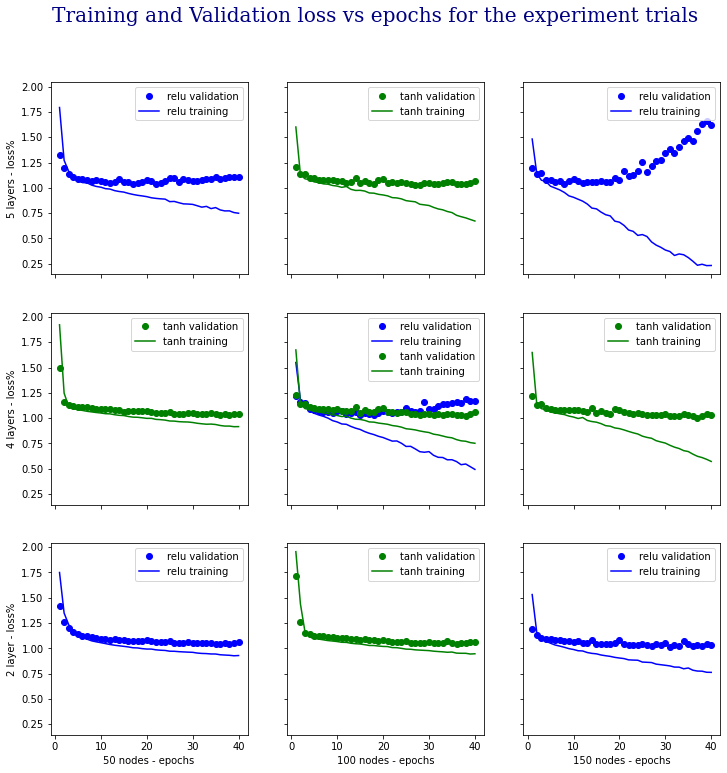

In [24]:
#visualise the experiment results
dic_spaces={50:0,100:1,150:2, 2:2,4:1,5:0}
epochs_range=range(1,epochs+1)
fig, axs= plt.subplots(3,3, sharey=True, sharex=True, figsize=(12,12))
plt.text(x=0.5, y=0.95, s="Training and Validation loss vs epochs for the experiment trials",
         fontdict={'family': 'serif','color':  'navy','weight': 'normal','size': 20}, ha="center", transform=fig.transFigure)
for trial in experiment_results:
    if trial.activation=='relu':
        axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].plot(epochs_range,trial.history.history['val_loss'], 'bo',
                                                                          label='relu validation')
        axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].plot(epochs_range,trial.history.history['loss'], 'b',
                                                                          label='relu training')    
    else:
        axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].plot(epochs_range,trial.history.history['val_loss'], 'go',
                                                                          label='tanh validation')
        axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].plot(epochs_range,trial.history.history['loss'], 'g',
                                                                          label='tanh training')
    if trial.hidden_layers==5:
        axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].set_ylabel('5 layers - loss%')
    elif trial.hidden_layers==4:
        axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].set_ylabel('4 layers - loss%')
    else:
        axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].set_ylabel('2 layer - loss%')
    if trial.nodes_no==50:
        axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].set_xlabel('50 nodes - epochs')
    elif trial.nodes_no==100:
        axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].set_xlabel('100 nodes - epochs')
    else:
        axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].set_xlabel('150 nodes - epochs')
    axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].legend()
    for ax in axs.flat:
        ax.label_outer()
plt.savefig('DoEresults.png', bbox_inches='tight')
plt.show() 

We can see that the models with the 'relu' activation function succeed faster in reducing the training loss function, which means that they learn faster from the training data, and, at the same time, they start to overfit earlier than the models with 'tanh' activation function.

In addition, we can see, as expected, that by scaling up the model by adding more layers and more nodes in each layer, the training and validation losses reduce faster as the number of epochs increases. However, we can see some increase in the validation loss for the larger models, especially a great increase in the validation loss for the largest model in the right top corner.

To evaluate this better, we could look only at the validation loss, from the 10th epoch onwards.

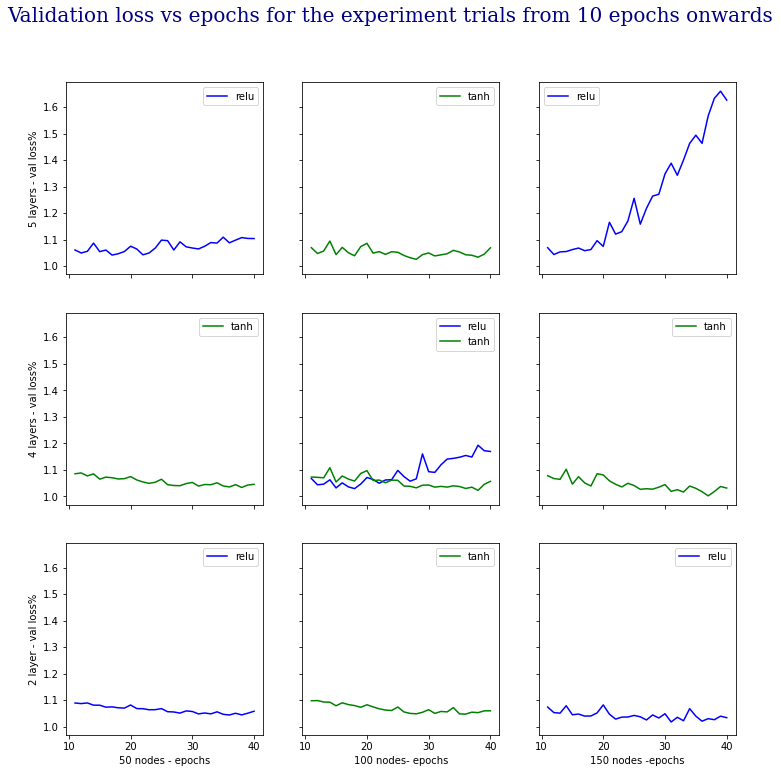

In [26]:
dic_spaces={50:0,100:1,150:2, 2:2,4:1,5:0}
epochs_range=range(10+1,epochs+1)
fig, axs= plt.subplots(3,3, sharey=True, sharex=True, figsize=(12,12))
plt.text(x=0.5, y=0.95, s="Validation loss vs epochs for the experiment trials from 10 epochs onwards",
         fontdict={'family': 'serif','color':  'navy','weight': 'normal','size': 20}, ha="center", transform=fig.transFigure)
for trial in experiment_results:
    if trial.activation=='relu':
        axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].plot(epochs_range,trial.history.history['val_loss'][10:], c='blue',label=trial.activation)
    else:
        axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].plot(epochs_range,trial.history.history['val_loss'][10:], c='green',label=trial.activation)
    if trial.hidden_layers==5:
        axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].set_ylabel('5 layers - val loss%')
    elif trial.hidden_layers==4:
        axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].set_ylabel('4 layers - val loss%')
    else:
        axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].set_ylabel('2 layer - val loss%')
    if trial.nodes_no==50:
        axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].set_xlabel('50 nodes - epochs')
    elif trial.nodes_no==100:
        axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].set_xlabel('100 nodes- epochs')
    else:
        axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].set_xlabel('150 nodes -epochs')
    axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].legend()
    for ax in axs.flat:
        ax.label_outer()
plt.show() 

The smaller models close to the bottom left corner, don't seem to have reached any plateau which is necessary before the overfitting. The intermediate size networks and the tanh big size networks have reached a plateau and we can see a clearly overfit for the biggest model with "relu" activation function as well as the central model with 'relu'.

There is, as well, an interest to see what is the minimum validation loss reached, which can give an indication of the highest performance of the model.

Although this graph is not the clearest way to see this, we can see how the model with 4 layers, 150 nodes per layer and 'tanh' has reached a very low loss as well as the central model with 'relu' activation function.

We can get the minimum validation losses and the maximum validation accuracy for each experiment and display them in a table and visualise the minimum validation loss for each experiment in a single 3D graph.


In [27]:
#Show the minumum validation loss and maximum validation accuracy for each experiment in a table
min_val_lossess=[]
max_val_accuracies=[]
for trial in experiment_results:
    min_val_lossess.append(trial.MinValLoss)
    max_val_accuracies.append(trial.MaxValAccuracy)
experiment_table['min_val_loss']=min_val_lossess
experiment_table['max_val_acc']=max_val_accuracies
experiment_table=experiment_table.sort_values(by=['trial'])
experiment_table

,trial,nodes_no,layers,activation,min_val_loss,max_val_acc
0,1,50,2,relu,1.043977,0.568707
2,2,50,4,tanh,1.033802,0.551020
8,3,50,5,relu,1.041940,0.582313
9,4,100,2,tanh,1.047488,0.552381
4,5,100,4,relu,1.029456,0.614966
5,6,100,4,tanh,1.022881,0.571429
7,7,100,5,tanh,1.025996,0.567347
6,8,150,2,relu,1.017632,0.583673
1,9,150,4,tanh,1.002190,0.602721
3,10,150,5,relu,1.038777,0.634014


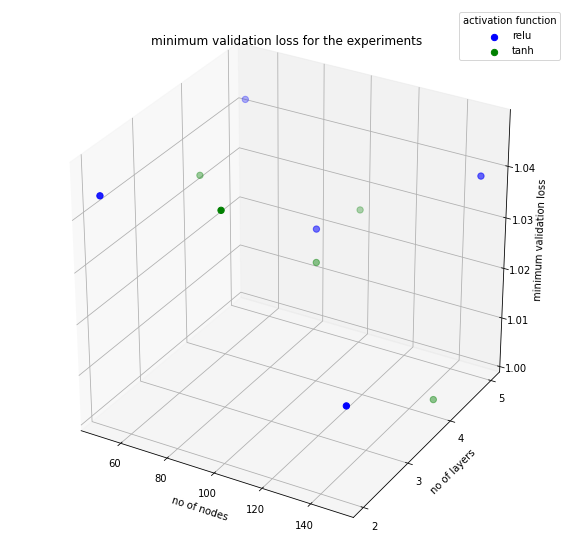

In [28]:
#Visualise the validation loss in a 3d plot
relu=experiment_table.loc[experiment_table['activation']=='relu']
tanh=experiment_table.loc[experiment_table['activation']=='tanh']
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(projection='3d')
ax.scatter3D(relu['nodes_no'],relu['layers'],relu['min_val_loss'], label='relu', c='blue',s=40)
ax.scatter3D(tanh['nodes_no'],tanh['layers'],tanh['min_val_loss'], label='tanh', c='green',s=40)
ax.set_xlabel('no of nodes')
ax.set_ylabel('no of layers')
ax.set_zlabel('minimum validation loss')
ax.set_yticks([2,3,4,5])
ax.set_title('minimum validation loss for the experiments')
ax.legend(title='activation function', bbox_to_anchor=(1.0, 1.0))
plt.savefig('3dplot.png', bbox_inches='tight')
plt.show()

We would like to continue working with a model that is capable of reaching a low validation loss and that slightly overfits so we can continue tunning the hyperparameters and add regularisation to optimise the model and reduce the overfitting.

We can see from the 3d plot that the model which reaches the lowest validation loss is the model with 4 layers and 150 nodes per layer with tanh activation function, however, this model doesn't seem to reach overfit.
In addition, we see that the model which reaches the highest maximum validation accuracy is the model with 5 layers, 150 nodes per layer with 'relu' activation however, it starts to overfit too fast during the training process.
We would like to continue exploring these two types of models for the next step.

## 7. Tune the hyperparameters, add regularisation and train and test the final model.

This last step includes many steps which we will follow one by one

7.a Tune the hyperparameters of the chosen models from the experiment

7.b Add regularisation into the best model of 7.a and evaluate the type of regularisation.

7.c Train the model of the best model with regularisation from 7.b with all the data and evaluate the model.

### 7.a Tune the hyperparameters.
From the latest conclusions, we would like to increase the size of the model (4 layers, 150 nodes, tanh) which gave the lowest validation loss but didn't reach overfit, we will do an additional similar trial with 5 layers.

Similarly, we would like to keep the same network size but change the activation function to 'relu', we would expect fast learning as the biggest model with 'relu' with less overfitting.

These two new trials are the continuation of the initial experiment.


In [29]:
more_experiment_table=pd.DataFrame({'trial':[11,12],'nodes_no':[150,150],
                               'layers':[4,5],'activation':['relu','tanh']})
more_experiment_table

,trial,nodes_no,layers,activation
0,11,150,4,relu
1,12,150,5,tanh


In [30]:
#Run the continuation of the experiment
for i in range(len(more_experiment_table)):
    model=build_model(more_experiment_table['layers'][i], more_experiment_table['nodes_no'][i], more_experiment_table['activation'][i])
    history=model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val,y_val), verbose=0)
    trial=Trial(more_experiment_table['nodes_no'][i], more_experiment_table['layers'][i], more_experiment_table['activation'][i],False,False,
              min(history.history['val_loss']), max(history.history['val_accuracy']), history)
    experiment_results.append(trial)

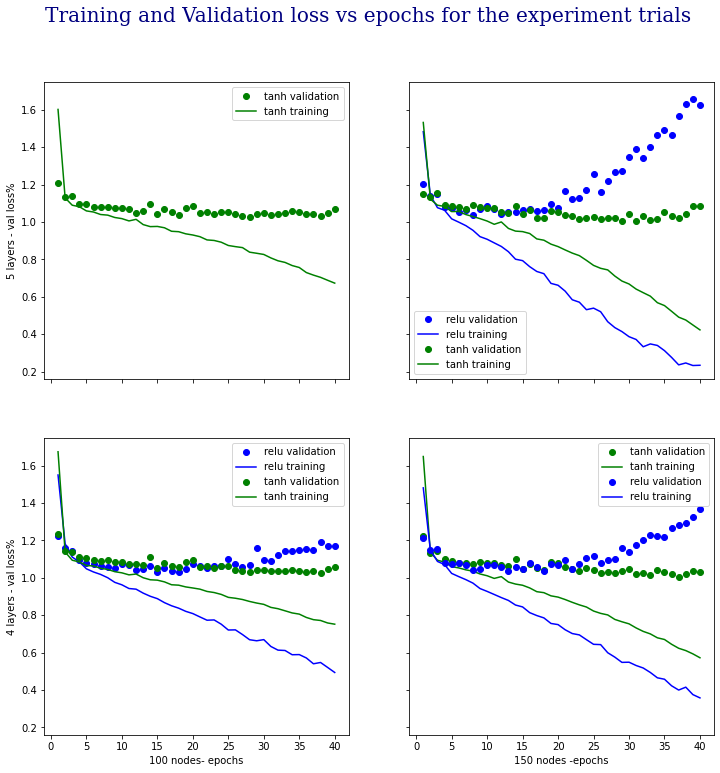

In [31]:
#this time we will visualise the new experiments together with the previous ones but we will plot only a small area of interest
dic_spaces={100:0,150:1,4:1,5:0}
epochs_range=range(1,epochs+1)
fig, axs= plt.subplots(2,2, sharey=True, sharex=True, figsize=(12,12))
plt.text(x=0.5, y=0.95, s="Training and Validation loss vs epochs for the experiment trials",
         fontdict={'family': 'serif','color':  'navy','weight': 'normal','size': 20}, ha="center", transform=fig.transFigure)
for trial in experiment_results:
    if not trial.hidden_layers==2 and not trial.nodes_no==50:
        if trial.activation=='relu':
            axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].plot(epochs_range,trial.history.history['val_loss'],
                                                                                  'bo', label='relu validation')
            axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].plot(epochs_range,trial.history.history['loss'],
                                                                                  'b', label='relu training')
        else:
            axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].plot(epochs_range,trial.history.history['val_loss'],
                                                                                  'go', label='tanh validation')
            axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].plot(epochs_range,trial.history.history['loss'], 
                                                                                  'g', label='tanh training')
        if trial.hidden_layers==5:
            axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].set_ylabel('5 layers - val loss%')
        elif trial.hidden_layers==4:
            axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].set_ylabel('4 layers - val loss%')
        if trial.nodes_no==100:
            axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].set_xlabel('100 nodes- epochs')
        else:
            axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].set_xlabel('150 nodes -epochs')
        axs[dic_spaces[trial.hidden_layers]][dic_spaces[trial.nodes_no]].legend()
        for ax in axs.flat:
            ax.label_outer()
plt.savefig('resultsAfterTunning.png', bbox_inches='tight')
plt.show() 

In [32]:
#we can see the results of the new experiments together with the previous ones in the following table
min_val_lossess=[]
max_val_accuracies=[]
for trial in experiment_results[-2:]:
    min_val_lossess.append(trial.MinValLoss)
    max_val_accuracies.append(trial.MaxValAccuracy)
more_experiment_table['min_val_loss']=min_val_lossess
more_experiment_table['max_val_acc']=max_val_accuracies
experiment_table=pd.concat([experiment_table,more_experiment_table], axis=0)
experiment_table

,trial,nodes_no,layers,activation,min_val_loss,max_val_acc
0,1,50,2,relu,1.043977,0.568707
2,2,50,4,tanh,1.033802,0.551020
8,3,50,5,relu,1.041940,0.582313
9,4,100,2,tanh,1.047488,0.552381
4,5,100,4,relu,1.029456,0.614966
5,6,100,4,tanh,1.022881,0.571429
7,7,100,5,tanh,1.025996,0.567347
6,8,150,2,relu,1.017632,0.583673
1,9,150,4,tanh,1.002190,0.602721
3,10,150,5,relu,1.038777,0.634014


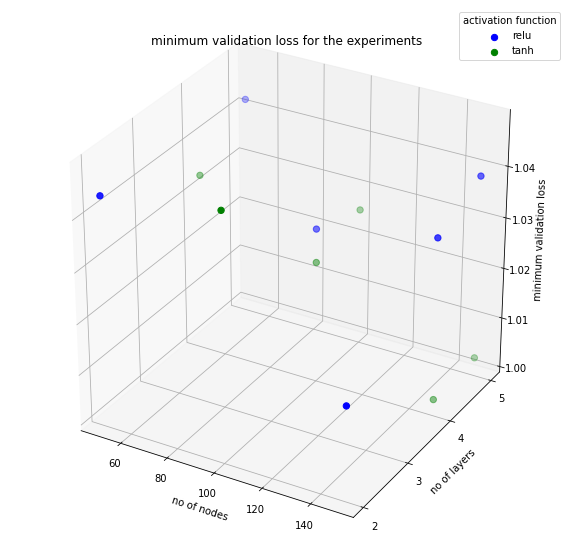

In [33]:
#and we can visualise the minimum validation loss of all the experiments together in the 3d plot
relu=experiment_table.loc[experiment_table['activation']=='relu']
tanh=experiment_table.loc[experiment_table['activation']=='tanh']
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(projection='3d')
ax.scatter3D(relu['nodes_no'],relu['layers'],relu['min_val_loss'], label='relu', c='blue',s=40)
ax.scatter3D(tanh['nodes_no'],tanh['layers'],tanh['min_val_loss'], label='tanh', c='green',s=40)
ax.set_xlabel('no of nodes')
ax.set_ylabel('no of layers')
ax.set_zlabel('minimum validation loss')
ax.set_yticks([2,3,4,5])
ax.set_title('minimum validation loss for the experiments')
ax.legend(title='activation function',bbox_to_anchor=(1.0, 1.0))
plt.savefig('3dplotaftertunning.png', bbox_inches='tight')
plt.show()

The two new experiments were successful, the experiment with 5 layers, 150 nodes and 'tanh' reached a lower minimum validation loss than the model with 4 layers, a higher maximum validation accuracy and reached overfit after the 35th epoch.
Similarly, the experiment with 4 layers, 150 nodes per layer and 'relu' showed a simpler model that reached a lower minimum validation loss than the model with 5 layers and started overfitting at a smaller rate than the latest.

Comparing these two new models, the first one, with tanh activation function, seems to be better, reaching the lowest minimum validation loss and the highest maximum accuracy, however, as we see that generally 'relu' models tend to learn faster than the 'tanhs' models, the 'relu' model could get more benefits when we add the regularisation in the next step.

We will continue to 7.b with the 2 models adding regularisation to both of them and then we will decide on the best model for the 7.c step.

### 7.b Add regularisation
There are two types of regularisation techniques, the addition of a regulariser for the weight updates and the addition of dropout layers. We would carry out a few more experiments where we are going to apply a different combination of regularisation techniques to the models we have chosen to work on in the previous step.

For this, we will create a new function that builds models with regularisation and we will create a table with the required hyperparameters for the new experiments.

In [34]:
# contructing a new function which creates a model with the option of regularisation techniques addition
from tensorflow.keras import regularizers
def build_model_regulariser(hidden_layers=1,nodes_no=8, activation='relu',reg=False, dropout=False):
    model=models.Sequential()
    for i in range(hidden_layers):
        if i==0:
            if reg:
                model.add(layers.Dense(nodes_no, activation=activation, kernel_regularizer = regularizers.l2(0.0001),
                                       input_shape=(11,)))
            else:
                model.add(layers.Dense(nodes_no, activation=activation, input_shape=(11,)))
        else:
            if reg:
                model.add(layers.Dense(nodes_no, activation=activation, kernel_regularizer = regularizers.l2(0.0001)))
            else:
                model.add(layers.Dense(nodes_no, activation=activation))
        if dropout:
            model.add(layers.Dropout(0.3))
    model.add(layers.Dense(10, activation = 'softmax'))
    model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['accuracy'])
    return model

In [35]:
reg_experiment_table=pd.DataFrame({'trial':[13,14,15,16,17,18],'nodes_no':[150,150,150,150,150,150],'layers':[4,4,4,5,5,5],
                                   'activation':['relu','relu','relu', 'tanh','tanh','tanh'],
                                   'reg':[True,False,True,True,False,True],'dropout':[False,True,True,False,True,True]})
reg_experiment_table

,trial,nodes_no,layers,activation,reg,dropout
0,13,150,4,relu,True,False
1,14,150,4,relu,False,True
2,15,150,4,relu,True,True
3,16,150,5,tanh,True,False
4,17,150,5,tanh,False,True
5,18,150,5,tanh,True,True


In [36]:
#store the new results together with the 2 last previous models
reg_experiment_results=experiment_results[-2:]

In [37]:
#run the experiment for regularisation
#we will use a higher number of epochs as the regularisation reduces and delays the overfiting
reg_epochs=80
for i in range(len(reg_experiment_table)):
    model=build_model_regulariser(reg_experiment_table['layers'][i], reg_experiment_table['nodes_no'][i],
                                  reg_experiment_table['activation'][i], reg_experiment_table['reg'][i],
                                  reg_experiment_table['dropout'][i])
    history=model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=reg_epochs,
                    validation_data=(x_val,y_val), verbose=0)
    trial=Trial(experiment_table['nodes_no'][i], experiment_table['layers'][i], experiment_table['activation'][i],
                reg_experiment_table['reg'][i],reg_experiment_table['dropout'][i],min(history.history['val_loss']),
                max(history.history['val_accuracy']), history)
    reg_experiment_results.append(trial)

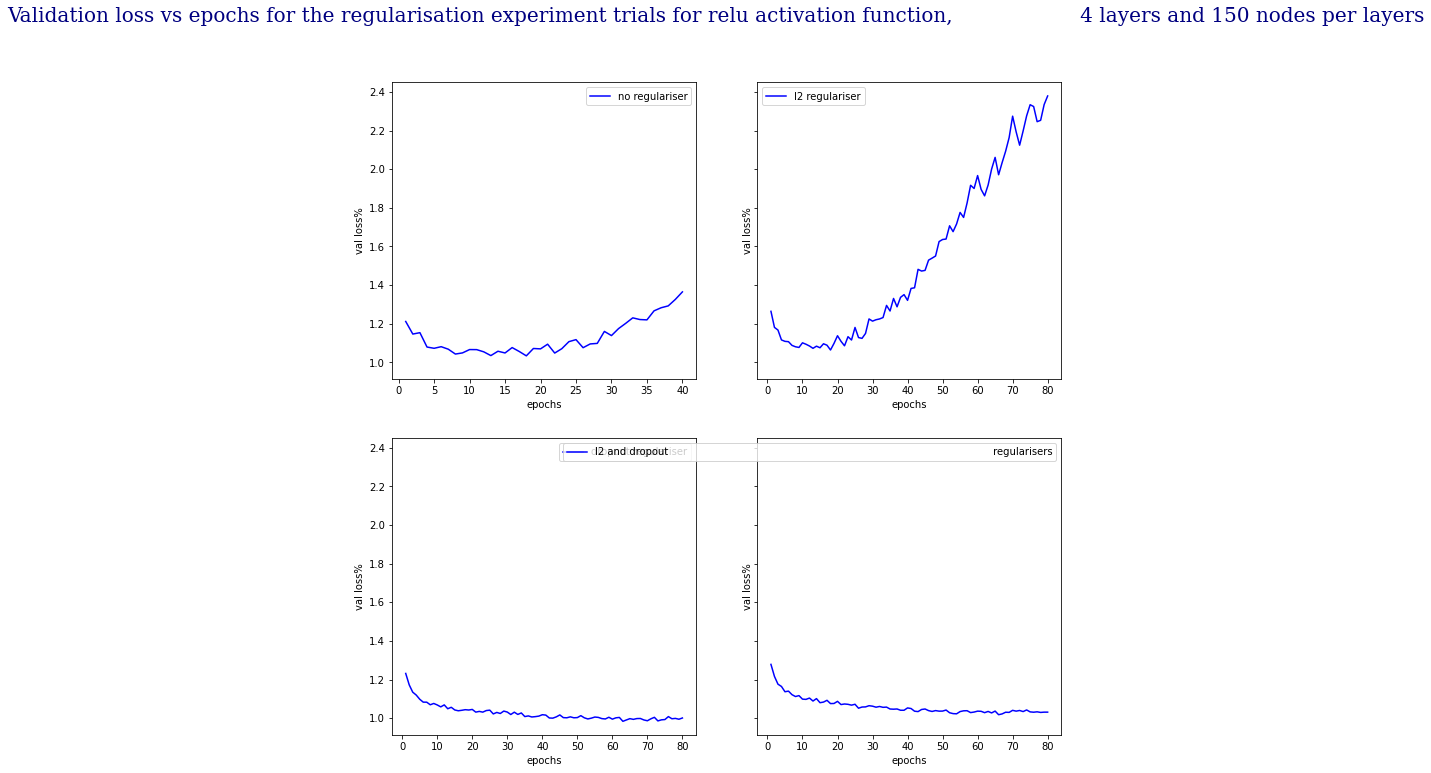

In [38]:
#visualise the results for the regularisation experiments using the model with relu
epochs_range=range(1,epochs+1)
reg_epochs_range=range(1,reg_epochs+1)
fig, axs= plt.subplots(2,2, sharey=True, figsize=(12,12))
plt.text(x=0.5, y=0.95, s="Validation loss vs epochs for the regularisation experiment trials for relu activation function,\
                    4 layers and 150 nodes per layers",
         fontdict={'family': 'serif','color':  'navy','weight': 'normal','size': 20}, ha="center", transform=fig.transFigure)

axs[0][0].plot(epochs_range,reg_experiment_results[0].history.history['val_loss'], c='blue',label='no regulariser')
axs[0][1].plot(reg_epochs_range,reg_experiment_results[2].history.history['val_loss'], c='blue',label='l2 regulariser')
axs[1][0].plot(reg_epochs_range,reg_experiment_results[3].history.history['val_loss'], c='blue',label='dropout regulariser')
axs[1][1].plot(reg_epochs_range,reg_experiment_results[4].history.history['val_loss'], c='blue',label='l2 and dropout\
                                                                                                        regularisers')   
for i in range(2):
    for j in range(2):
        axs[i][j].set_ylabel('val loss%')
        axs[i][j].set_xlabel('epochs')
        axs[i][j].legend()
plt.savefig('resultsReluAfterReg.png', bbox_inches='tight')
plt.show() 

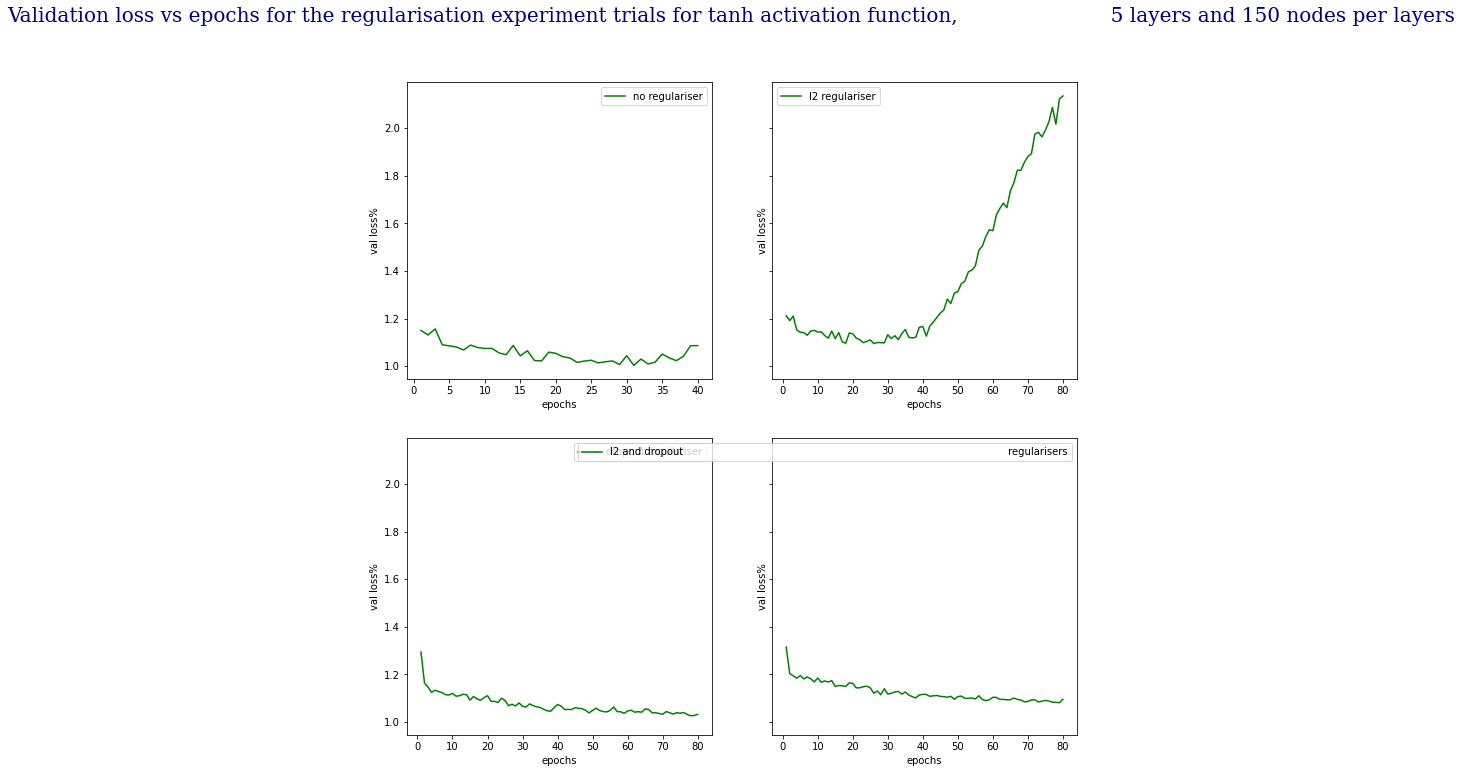

In [39]:
#visualise the results for the regularisation experiments using the model with tanh
epochs_range=range(1,epochs+1)
reg_epochs_range=range(1,reg_epochs+1)
fig, axs= plt.subplots(2,2, sharey=True, figsize=(12,12))
plt.text(x=0.5, y=0.95, s="Validation loss vs epochs for the regularisation experiment trials for tanh activation function,\
                        5 layers and 150 nodes per layers",
         fontdict={'family': 'serif','color':  'navy','weight': 'normal','size': 20}, ha="center", transform=fig.transFigure)

axs[0][0].plot(epochs_range,reg_experiment_results[1].history.history['val_loss'], c='green',label='no regulariser')
axs[0][1].plot(reg_epochs_range,reg_experiment_results[5].history.history['val_loss'], c='green',label='l2 regulariser')
axs[1][0].plot(reg_epochs_range,reg_experiment_results[6].history.history['val_loss'], c='green',label='dropout regulariser')
axs[1][1].plot(reg_epochs_range,reg_experiment_results[7].history.history['val_loss'], c='green',label='l2 and dropout\
                                                                                                        regularisers')   
for i in range(2):
    for j in range(2):
        axs[i][j].set_ylabel('val loss%')
        axs[i][j].set_xlabel('epochs')
        axs[i][j].legend()
plt.savefig('resultstanhAfterReg.png', bbox_inches='tight')
plt.show() 

In [40]:
#tabulate the results in a table
min_val_lossess_reg=[]
max_val_accuracies_reg=[]
for i in range(2,len(reg_experiment_results)):
    min_val_lossess_reg.append(reg_experiment_results[i].MinValLoss)
    max_val_accuracies_reg.append(reg_experiment_results[i].MaxValAccuracy)
reg_experiment_table['min_val_loss']=min_val_lossess_reg
reg_experiment_table['max_val_acc']=max_val_accuracies_reg
reg_experiment_table

,trial,nodes_no,layers,activation,reg,dropout,min_val_loss,max_val_acc
0,13,150,4,relu,True,False,1.064398,0.646259
1,14,150,4,relu,False,True,0.984102,0.582313
2,15,150,4,relu,True,True,1.018353,0.601361
3,16,150,5,tanh,True,False,1.094836,0.619048
4,17,150,5,tanh,False,True,1.025953,0.564626
5,18,150,5,tanh,True,True,1.080804,0.564626


From the above graphs and table, we can see that the trials with only the dropout regulariser achieved the lowest minimum validation loss as well as the expected validation loss curve, which shows less oscillation and no overfit within the training process, even though the number of epochs has been doubled from the initial trials.

Moreover, we can see that the trial with 'relu' activation function has taken more advantage of the regularisation techniques, showing lower minimum validation loss and higher maximum validation accuracy than the model with 'tanh' activation function.

However, if we want to continue working with the dropout regulariser, we should carry more experiments with a higher number of epochs to achieve even lower validation loss, higher validation accuracy and understand the optimal number of epochs for the final model.

In [41]:
#let's see if we can bet lower loss with the dropout regulariser with more epochs
epochs=350
model2=build_model_regulariser(4, 150, 'relu', False,True)
history2=model2.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val,y_val), verbose=0)
dropouttrial=Trial(150, 4,'relu',False, True, min(history2.history['val_loss']), max(history2.history['val_accuracy']), history2)

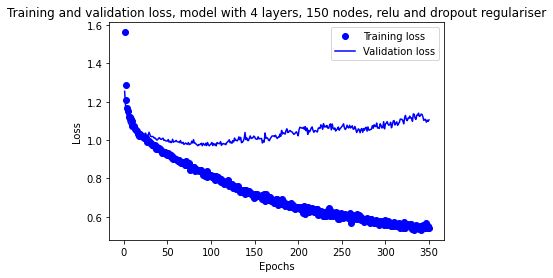

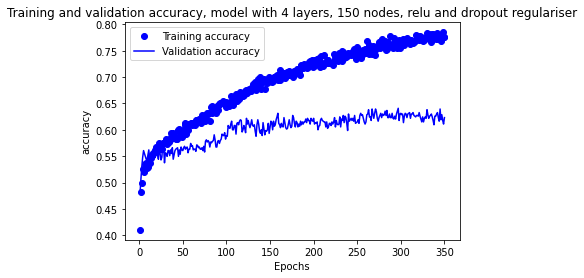

In [42]:
dropouttrial.plot_loss_vs_epochs(epochs)
dropouttrial.plot_accuracy_vs_epochs(epochs)

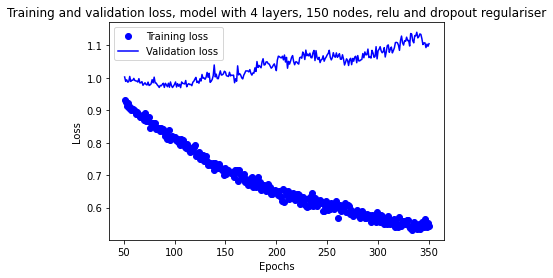

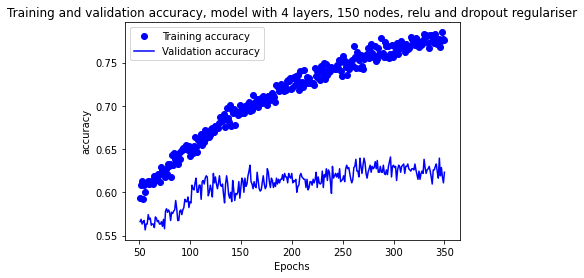

In [43]:
#visualise from the 50th epoch
dropouttrial.plot_loss_vs_epochs(epochs,50)
dropouttrial.plot_accuracy_vs_epochs(epochs,50)

In [44]:
#let's see if we can bet lower loss with the dropout regulariser with more epochs for the model with tanh activation function
epochs=350
model3=build_model_regulariser(5, 150, 'tanh', False,True)
history3=model3.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val,y_val), verbose=0)
dropouttrialtanh=Trial(150, 5,'tanh',False, True, min(history3.history['val_loss']), max(history3.history['val_accuracy']), history3)


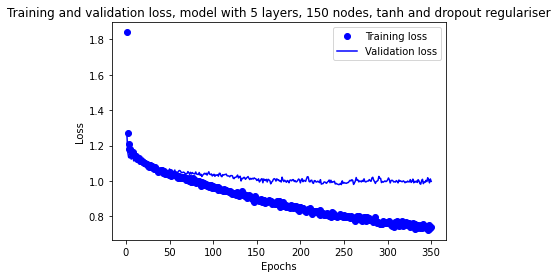

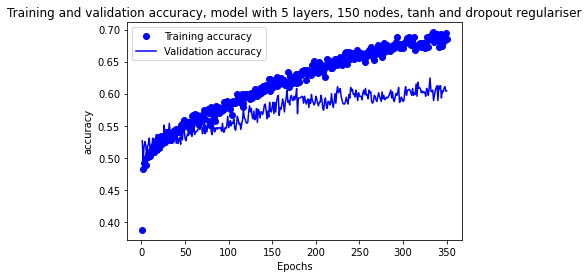

In [45]:
dropouttrialtanh.plot_loss_vs_epochs(epochs)
dropouttrialtanh.plot_accuracy_vs_epochs(epochs)


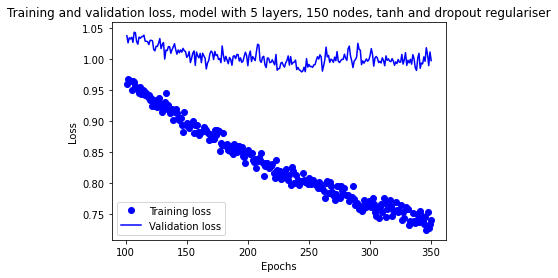

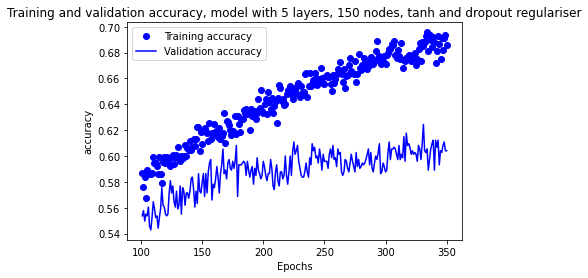

In [46]:
dropouttrialtanh.plot_loss_vs_epochs(epochs,100)
dropouttrialtanh.plot_accuracy_vs_epochs(epochs,100)

In [47]:
#visualise the latest results in a single table
reg_experiment_table['epochs']=[80,80,80,80,80,80]
dropouttrial_to_table=[19,150,4,'relu',False, True, dropouttrial.MinValLoss,dropouttrial.MaxValAccuracy,epochs]
dropouttrialtanh_to_table=[20,150,5,'tanh',False, True, dropouttrialtanh.MinValLoss,dropouttrialtanh.MaxValAccuracy,epochs]
do_series = pd.Series(dropouttrial_to_table, index = reg_experiment_table.columns)
dotanh_series=pd.Series(dropouttrialtanh_to_table, index = reg_experiment_table.columns)
reg_experiment_table = reg_experiment_table.append([do_series,dotanh_series], ignore_index=True)
reg_experiment_table

,trial,nodes_no,layers,activation,reg,dropout,min_val_loss,max_val_acc,epochs
0,13,150,4,relu,True,False,1.064398,0.646259,80
1,14,150,4,relu,False,True,0.984102,0.582313,80
2,15,150,4,relu,True,True,1.018353,0.601361,80
3,16,150,5,tanh,True,False,1.094836,0.619048,80
4,17,150,5,tanh,False,True,1.025953,0.564626,80
5,18,150,5,tanh,True,True,1.080804,0.564626,80
6,19,150,4,relu,False,True,0.969781,0.640816,350
7,20,150,5,tanh,False,True,0.979584,0.624490,350


After we have run the models with the optimal regulariser with a higher number of epochs, we can see again that the 'relu' model has achieved the lowest minimum validation loss as well as the highest maximum validation accuracy, taking more advantage of the regulariser than the tanh model.

In addition, we can see that the tanh model doesn't start to overfit but clearly get into a plateau for the validation loss and validation accuracy.

On the other hand, from the graphs with the relu model, we can see that the optimum number of epochs for the model with 'relu', 4 layers, 150 nodes, and dropout regulariser is around 125.

### 7.c Train the model of the best model with regularisation from 7.b with all the data and evaluate the model.

We will take the hyperparameters of this last model for the final model, train it for using 125 epochs and evaluate it.

In [48]:
#select the final number of epochs
final_epochs=125
#join the training and validation data as a final training set
x_train_final=np.concatenate((x_train,x_val))
y_train_final=np.concatenate((y_train,y_val))

In [49]:
#build the model and train it
final_model=build_model_regulariser(4, 150, 'relu', False,True)
history_final=final_model.fit(x_train_final,
                    y_train_final,
                    batch_size=batch_size,
                    epochs=epochs, verbose=0)

# Final Results

In [50]:
#Evaluate the model
final_model.evaluate(x_test,y_test)

23/23 [==============================] - 0s 2ms/step - loss: 0.9619 - accuracy: 0.6762


[0.961926281452179, 0.6761904954910278]

In [51]:
#get the prediction for the test set
predictions=final_model.predict(x_test)
#getting back to single label
pred_label=np.argmax(predictions, axis=1)
#get back to single label for the real data
true_label=np.argmax(y_test, axis=1)

In [52]:
#Create a confusion matrix
matrix=tf.math.confusion_matrix(true_label, pred_label)

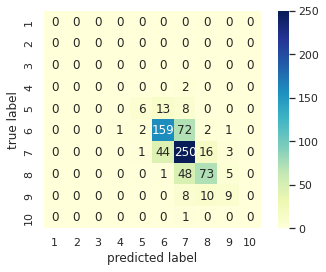

In [54]:
unique_labels=range(1,11)
import seaborn as sns
sns.set()
sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=True,cmap="YlGnBu",
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.savefig('confmatrix.png',bbox_inches='tight')
plt.show()

# Conclusions

The final model has achieved a 67.62% accuracy which is slightly higher than the latest validation accuracy we have achieved before. From this, we can conclude that the validation protocol was successful and there was no need for k-fold validation.

Furthermore, we have increased the accuracy for more than 12% from the initial simple model with a single input layer. And we have increased by almost 20% from the baseline model using the dummy classifier. Hence, we created a model with statistical power.

Looking back at our initial hypothesis:
1.  
We can predict the wine quality given the physicochemical properties in the dataset.
2. The available dataset is informative enough to learn the relationship between the wine properties and its sensory quality.

We can conclude for the 1st one that we can predict the wine quality with 67.62% accuracy given the physicochemical properties of the wine.
For the second hypothesis, we conclude that the available dataset is partially informative to learn the relationship between the wine properties and its sensory quality.

On one hand, we have taken the model to the maximum accuracy we could get by exploring different hyperparameters and regularisation techniques which lead to a much higher accuracy than was measured on the simpler model. But, on the other hand, the model isn't accurate enough to be proposed as a wine quality predictor to the wineries.

As we can see from the confusion matrix, the samples which weren't correctly classified, were generally confused with classes that are mostly similar to the original class, from this we can suggest two possible ways to improve the model:

1. Present the problem as a regression model rather than a multiclass classification.
2. Do feature engineering and join a few classes together, for example, labels up to 4 could be considered low quality, classes 5 and 6 as middle quality and 7 and higher to be considered as high quality. However, this should be discussed with a wine expert to understand where to put exactly the threshold levels.

Additionally, as for any other machine learning model, the best way to improve the model would be to get more data. For this particular example, more data of wines of low quality, classified as 4 or low and very high quality, classified as 8 or high should be added. Furthermore, other wine properties could be added such as the grape type and soil conditions. 
